# Part 2:

## Autoencoder for Anomaly Detection

Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop
from time import time
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow
print(tensorflow.__version__)

2.3.0


Tensorflow need to be updated to 2.3.0 for Conv1DTranspose to work

You will need to uncomment and run the below cell inorder to upgrade tensorflow if its still 2.2.0

In [ ]:
# pip install --upgrade tensorflow 
# !pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 48kB/s 
     |████████████████████████████████| 6.8MB 40.9MB/s 
     |████████████████████████████████| 460kB 44.3MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0


## Picking a Dataset:

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `realAdExchange/exchange-2_cpc_results.csv` file for training and the `realAdExchange/exchange-3_cpc_results.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.


In [16]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"


df_cpc_exchange2_url_suffix = "realAdExchange/exchange-2_cpc_results.csv"
df_cpc_exchange2_url = master_url_root + df_cpc_exchange2_url_suffix
df_cpc_normal = pd.read_csv(df_cpc_exchange2_url)

df_cpc_exchange3_url_suffix = "realAdExchange/exchange-3_cpc_results.csv"
df_cpc_exchange3_url = master_url_root + df_cpc_exchange3_url_suffix
df_cpc_with_anamoly = pd.read_csv(df_cpc_exchange3_url)


## Quick look at the data


In [17]:
print(df_cpc_normal.head())

print(df_cpc_with_anamoly.head())


             timestamp     value
0  2011-07-01 00:00:01  0.081965
1  2011-07-01 01:00:01  0.098972
2  2011-07-01 02:00:01  0.065314
3  2011-07-01 03:00:01  0.070663
4  2011-07-01 04:00:01  0.102490
             timestamp     value
0  2011-07-01 00:15:01  0.102709
1  2011-07-01 01:15:01  0.068039
2  2011-07-01 02:15:01  0.077994
3  2011-07-01 03:15:01  0.077682
4  2011-07-01 04:15:01  0.077966


## Defining a function to Visualize the data and along with axis adjustment if required


In [113]:

def plot_dates_values(data, adjust = False, show_dates = False):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    if adjust is True:
      ax.set_ylim([0,1])
    plt.plot(dates, values)
    plt.show()
    if show_dates is True:
      d = []
      for i in dates:
        d.append(str(i.month) + str(i.day))
      print("Number of time points in the data: ",len(d))
      print("Number of days in the data",len(set(d)))
      print("We can see below that there are only 15 records instead of 24 on the last day")
      print(data.timestamp[-18:])



### Timeseries data without anomalies

We will use the following data for training.


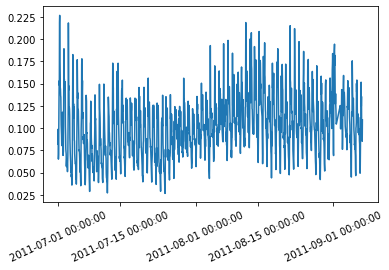

In [114]:
plt.title('Ad Exchange Cost per Clicks (Without Anomalies)')
plot_dates_values(df_cpc_normal)


### Timeseries data with anomalies

We will use the following data for testing. We can clearly observe the Anomalies in the data (for example, the sudden spikes can be considered as anomalies).


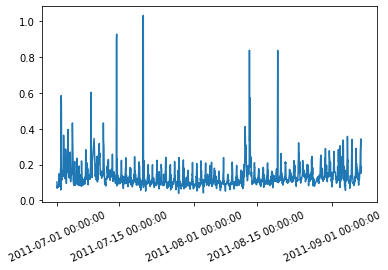

In [20]:
plot_dates_values(df_cpc_with_anamoly)

## Plotting the same above data with anomalies with the scale similar to scale of normal data.

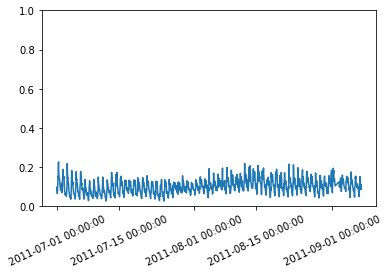

Number of time points in the data:  1624
Number of days in the data 69
We can see below that there are only 15 records instead of 24 on the last day
1606    2011-09-06 22:00:01
1607    2011-09-06 23:00:01
1608    2011-09-07 00:00:01
1609    2011-09-07 01:00:01
1610    2011-09-07 02:00:01
1611    2011-09-07 03:00:01
1612    2011-09-07 04:00:01
1613    2011-09-07 05:00:01
1614    2011-09-07 06:00:01
1615    2011-09-07 07:00:01
1616    2011-09-07 08:00:01
1617    2011-09-07 09:00:01
1618    2011-09-07 10:00:01
1619    2011-09-07 11:00:01
1620    2011-09-07 12:00:01
1621    2011-09-07 13:00:01
1622    2011-09-07 14:00:01
1623    2011-09-07 15:00:01
Name: timestamp, dtype: object


In [21]:
plot_dates_values(df_cpc_normal,adjust=True,show_dates=True)


## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 1 hour for 69 days.

-  **24 timesteps per day**

Data is from 2011-07-01 to 2011-09-07 = 69 days
-   **1624 data points** in total


In [115]:

def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_cpc_normal)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)


1624

## Defining TIMESTEPS

In [116]:
TIME_STEPS = 24

### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.


In [117]:
# TIME_STEPS = 24


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into a convolutional layer.
    return np.expand_dims(output, axis=2) , np.asarray(output)


x_train, x_train_dense = create_sequences(training_value)
print("Training input shape: ", x_train.shape)
print("Training input shape for dense autoencoder: ", x_train_dense.shape)


Training input shape:  (1600, 24, 1)
Training input shape for dense autoencoder:  (1600, 24)


## Building and training a MLP with dense layers to form an autoencoders:

In [132]:
dense_model = Sequential()


dense_model.add(Dense(128, input_dim = TIME_STEPS)) 
dense_model.add(BatchNormalization())
dense_model.add(LeakyReLU())
# dense_model.add(Dropout(0.2))

dense_model.add(Dense(64))
dense_model.add(BatchNormalization())
dense_model.add(LeakyReLU())
# dense_model.add(Dropout(0.1))

dense_model.add(Dense(16))#, kernel_regularizer='l2'))# , activity_regularizer=regularizers.l2(0.01))) #regularizers.l1_l2(0.01,0.01)))
dense_model.add(BatchNormalization())
dense_model.add(LeakyReLU())
# dense_model.add(Dropout(0.1))

dense_model.add(Dense(64))
dense_model.add(BatchNormalization())
dense_model.add(LeakyReLU())


dense_model.add(Dense(128))
dense_model.add(BatchNormalization())
dense_model.add(LeakyReLU())
# dense_model.add(Dropout(0.1))

dense_model.add(Dense(TIME_STEPS))
dense_model.add(Activation('softmax'))

optimizer = Adam()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
dense_model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['accuracy'])
dense_model.summary()

history_dense = dense_model.fit(x_train_dense, x_train_dense,
                  #  nb_epoch=150,
                  epochs=64,
                   batch_size=32,
                   verbose=1,
                   validation_split=0.1,
                   shuffle=True,
                   callbacks=[reduce_lr]
                   )

##, keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               3200      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)              

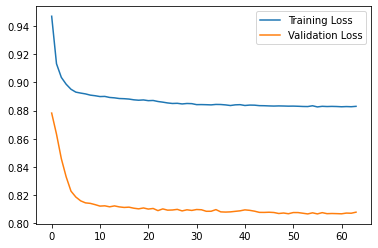

In [142]:
plt.plot(history_dense.history["loss"], label="Training Loss")
plt.plot(history_dense.history["val_loss"], label="Validation Loss")
plt.legend()

dense_autoencoder_loss = history_dense.history["val_loss"]

## Defining a function to calculate loss

In [134]:
from sklearn.metrics.pairwise import cosine_similarity
# Get train MAE loss.
def calculate_loss(model,training_data = x_train_dense):
  x_train_pred = model.predict(training_data)
  
  pred_loss = np.mean(np.abs(x_train_pred - training_data), axis=1)
  
  return pred_loss, x_train_pred




## Defining threshold and plotting Absolute loss

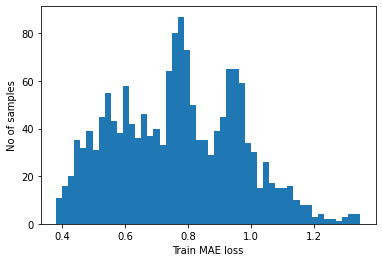

Reconstruction error threshold:  1.3493178102721888


In [135]:
train_mae_loss, pred_data = calculate_loss(dense_model,x_train_dense)


plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the second sample.
This is the 24 timesteps from day 2 of our training dataset.


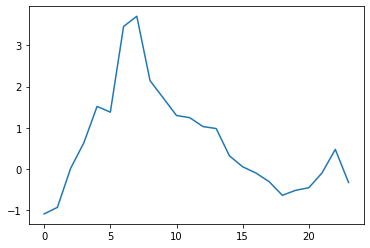

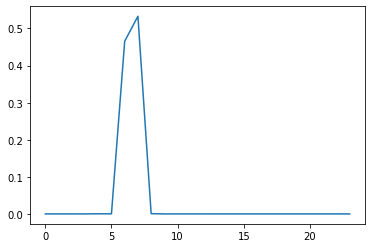

In [136]:
# Checking how the first sequence is learnt
plt.plot(x_train_dense[2])
plt.show()
plt.plot(pred_data[2])
plt.show()


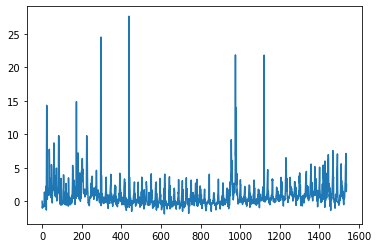

Test input shape:  (1514, 24)


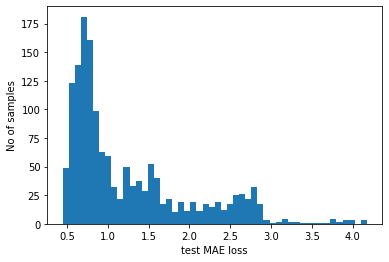

Number of anomaly samples:  494
Indices of anomaly samples:  (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,  146,  147,
        148,  149,  150,  151,  152,  153,  154,  155,  156,  157,  158,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,
        170,  171,  172,  173,  174,  175,  176,  177,  178,  179,  180,
        181,  182,  183,  184,  185,  186,  187,  188,  189,  190,  191,
        192,  193,  194,  195,  196,  197,  198,  199,  200,  

In [137]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_cpc_with_anamoly)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
_, x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
test_mae_loss, _ = calculate_loss(dense_model,x_test)

test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


## Plot anomalies. ( Content in this header was taken from the demo for better explanation)

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.


In [138]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
def extract_anomalous_indices(TIME_STEPS,anomalies,test_len):
  anomalous_data_indices = []
  for data_idx in range(TIME_STEPS - 1, test_len - TIME_STEPS + 1):
    
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
      temp = [data_idx-1,data_idx,data_idx+1] # if data_idx > 0 else [data_idx,data_idx+1]
      
      anomalous_data_indices.append(temp)
  return anomalous_data_indices

Let's overlay the anomalies on the original test data plot.


In [139]:
def plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly):
  df_highlighted_anamoly = []
  for i in anomalous_data_indices:
    df_subset = df_cpc_with_anamoly.iloc[i, :]
    df_highlighted_anamoly.append(df_subset)

  plt.subplots_adjust(bottom=0.2)
  plt.xticks(rotation=25)
  ax = plt.gca()
  xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
  ax.xaxis.set_major_formatter(xfmt)

  dates = df_cpc_with_anamoly["timestamp"].to_list()
  dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
  values = df_cpc_with_anamoly["value"].to_list()
  plt.plot(dates, values, label="test data")#, color="g")

  for anamoly in df_highlighted_anamoly[:-1]:
    dates = anamoly["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = anamoly["value"].to_list()
    plt.plot(dates, values, color="r")
  # print(values,len(values))
  anamoly = df_highlighted_anamoly[-1]
  dates = anamoly["timestamp"].to_list()
  dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
  values = anamoly["value"].to_list()
  plt.plot(dates, values,label="Anamoly", color="r")

  plt.legend()
  plt.show()


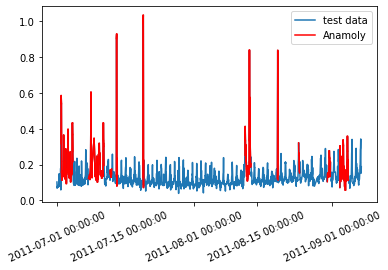

In [140]:
test_len = len(test_value)
anomalous_data_indices = extract_anomalous_indices(TIME_STEPS,anomalies,test_len)
## Storing number of time points classified as anamolies
dense_ae_anomaly_count = len(anomalous_data_indices)
plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly)

## Observation:

By looking at the reconstructed plot and the anomalies detected, we can clearly see that the autoencoder model created using MLP had not detected as much as anomalies as present and also the reconstructed plot of normal data was not up to the mark. But this model has detected anomalies comparatively  better than the MLP model from part1.

## Building autoencoders using LSTM setup

In [129]:
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

In [148]:
LSTM_model = Sequential()

LSTM_model.add(LSTM(128, activation='relu', input_shape=(TIME_STEPS,1)))
LSTM_model.add(Dropout(0.1))
LSTM_model.add(RepeatVector(TIME_STEPS))

LSTM_model.add(LSTM(64,activation='relu', return_sequences=True))
LSTM_model.add(Dropout(0.2))


LSTM_model.add(LSTM(64,activation='relu', return_sequences=True))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(128,activation='relu', return_sequences=True))
LSTM_model.add(Dropout(0.2))


LSTM_model.add(TimeDistributed(Dense(1)))

optimizer=Adam()

LSTM_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 24, 128)           0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 24, 64)            49408     
_________________________________________________________________
dropout_77 (Dropout)         (None, 24, 64)            0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
dropout_78 (Dropout)         (None, 24, 64)          

In [150]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
LSTM_model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['accuracy'])


history_LSTM = LSTM_model.fit(x_train, x_train,
                  #  nb_epoch=150,
                  epochs=32,
                   batch_size=32,
                   verbose=1,
                   validation_split=0.1,
                   shuffle=True,
                   callbacks=[reduce_lr]
                   )

Epoch 1/32
45/45 [==============================] - 4s 94ms/step - loss: 0.7615 - accuracy: 0.0000e+00 - val_loss: 0.5806 - val_accuracy: 0.0000e+00
Epoch 2/32
45/45 [==============================] - 4s 81ms/step - loss: 0.5565 - accuracy: 0.0000e+00 - val_loss: 0.5284 - val_accuracy: 0.0000e+00
Epoch 3/32
45/45 [==============================] - 4s 85ms/step - loss: 0.5415 - accuracy: 0.0000e+00 - val_loss: 0.5106 - val_accuracy: 0.0000e+00
Epoch 4/32
45/45 [==============================] - 4s 85ms/step - loss: 0.4209 - accuracy: 0.0000e+00 - val_loss: 0.4114 - val_accuracy: 0.0000e+00
Epoch 5/32
45/45 [==============================] - 4s 86ms/step - loss: 0.3121 - accuracy: 0.0000e+00 - val_loss: 0.3759 - val_accuracy: 0.0000e+00
Epoch 6/32
45/45 [==============================] - 4s 86ms/step - loss: 0.2627 - accuracy: 0.0000e+00 - val_loss: 0.3495 - val_accuracy: 0.0000e+00
Epoch 7/32
45/45 [==============================] - 4s 85ms/step - loss: 0.2316 - accuracy: 0.0000e+00 - v

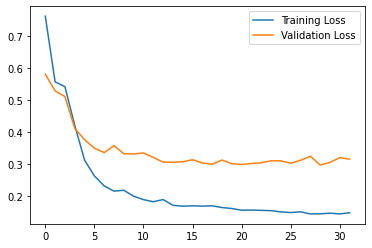

In [151]:
plt.plot(history_LSTM.history["loss"], label="Training Loss")
plt.plot(history_LSTM.history["val_loss"], label="Validation Loss")
plt.legend()

LSTM_autoencoder_loss = history_LSTM.history["val_loss"]

## Defining threshold and plotting Absolute loss

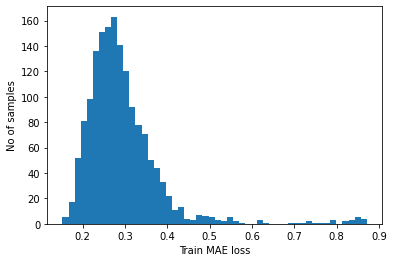

Reconstruction error threshold:  0.871270971026287


In [152]:
train_mae_loss, pred_data = calculate_loss(LSTM_model,x_train)


plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the second sample.
This is the 24 timesteps from day 2 of our training dataset.


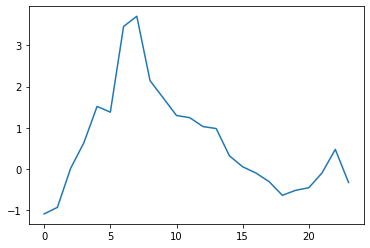

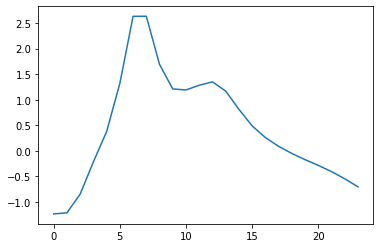

In [153]:
# Checking how the first sequence is learnt
plt.plot(x_train[2])
plt.show()
plt.plot(pred_data[2])
plt.show()


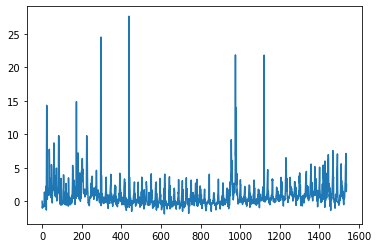

Test input shape:  (1514, 24, 1)


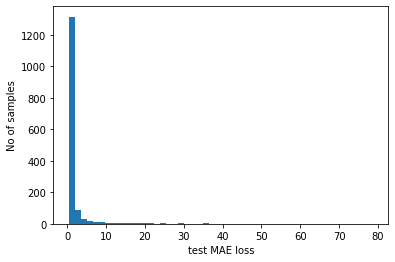

Number of anomaly samples:  568
Indices of anomaly samples:  (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,  102,  103,  104,
        105,  106,  132,  136,  147,  148,  149,  150,  151,  152,  153,
        154,  155,  156,  157,  158,  159,  160,  161,  162,  163,  164,
        165,  166,  167,  168,  169,  170,  171,  172,  173,  174,  175,
        176,  177,  178,  179,  180,  181,  182,  183,  184,  

In [154]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_cpc_with_anamoly)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test, _ = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
test_mae_loss, test_pred = calculate_loss(LSTM_model,x_test)

test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


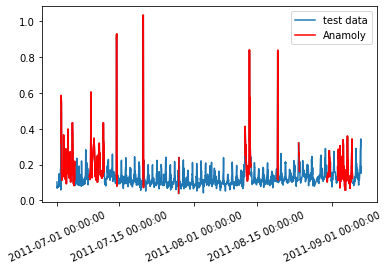

In [155]:
test_len = len(test_value)
anomalous_data_indices = extract_anomalous_indices(TIME_STEPS,anomalies,test_len)
LSTM_ae_anomaly_count = len(anomalous_data_indices)
plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly)

## Observation:

It is evident that LSTM autoencoder was better than autoencoder built using MLP in detecting anomalies. Validation loss was also less than the previous one.  
We can also observe that this autoencoder built by LSTM had almost reconstructed the original plot formed by normal data.

## Building a model with Conv1DLayers: 

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 24 and
`num_features` is 1.


In [158]:
import tensorflow as tf

In [159]:
model_1 = tf.keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        
        layers.Conv1D(
            filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),

        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
     

        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
     
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64, kernel_size=5, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_1.summary()


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 12, 64)            384       
_________________________________________________________________
dropout_84 (Dropout)         (None, 12, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 6, 32)             14368     
_________________________________________________________________
dropout_85 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3, 16)             3600      
_________________________________________________________________
conv1d_transpose_21 (Conv1DT (None, 6, 16)             1808      
_________________________________________________________________
dropout_86 (Dropout)         (None, 6, 16)           

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.


In [160]:
history_1 = model_1.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose = 1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
12/12 [==============================] - 0s 42ms/step - loss: 0.9814 - val_loss: 0.7472
Epoch 2/50
12/12 [==============================] - 0s 22ms/step - loss: 0.7619 - val_loss: 0.4964
Epoch 3/50
12/12 [==============================] - 0s 21ms/step - loss: 0.5052 - val_loss: 0.3578
Epoch 4/50
12/12 [==============================] - 0s 21ms/step - loss: 0.3693 - val_loss: 0.3248
Epoch 5/50
12/12 [==============================] - 0s 20ms/step - loss: 0.3116 - val_loss: 0.2849
Epoch 6/50
12/12 [==============================] - 0s 20ms/step - loss: 0.2798 - val_loss: 0.2741
Epoch 7/50
12/12 [==============================] - 0s 23ms/step - loss: 0.2557 - val_loss: 0.2458
Epoch 8/50
12/12 [==============================] - 0s 21ms/step - loss: 0.2418 - val_loss: 0.2307
Epoch 9/50
12/12 [==============================] - 0s 20ms/step - loss: 0.2242 - val_loss: 0.2158
Epoch 10/50
12/12 [==============================] - 0s 20ms/step - loss: 0.2139 - val_loss: 0.2026
Epoch 11/

Let's plot training and validation loss to see how the training went.


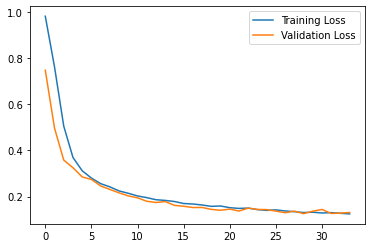

In [161]:
plt.plot(history_1.history["loss"], label="Training Loss")
plt.plot(history_1.history["val_loss"], label="Validation Loss")
plt.legend()

conv1_autoencoder_loss = history_1.history["val_loss"]

## Defining threshold and plotting Absolute loss

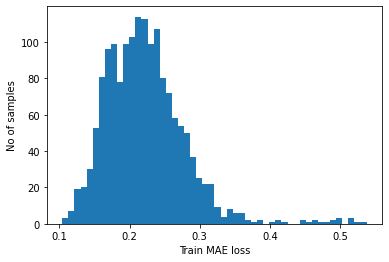

Reconstruction error threshold:  0.5377567854493958


In [162]:
train_mae_loss, pred_data = calculate_loss(model_1,x_train)


plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.


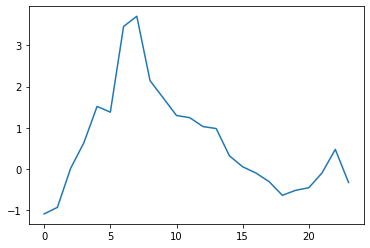

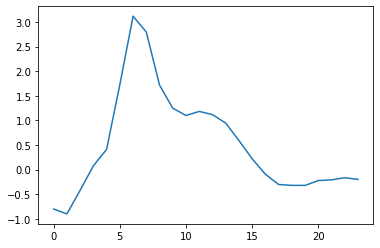

In [163]:
# Checking how the first sequence is learnt
plt.plot(x_train[2])
plt.show()
plt.plot(pred_data[2])
plt.show()


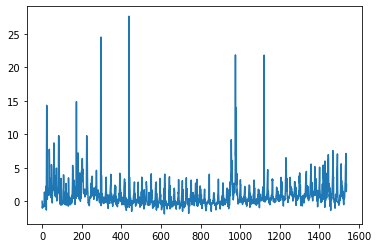

Test input shape:  (1514, 24, 1)


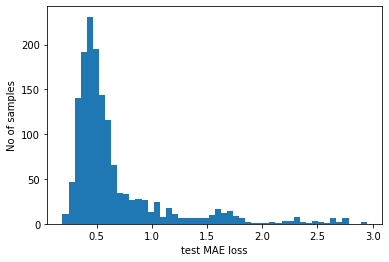

Number of anomaly samples:  656
Indices of anomaly samples:  (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   95,   96,   97,   99,  100,
        101,  102,  103,  105,  106,  107,  108,  110,  111,  112,  113,
        114,  115,  116,  117,  118,  131,  132,  134,  139,  143,  147,
        149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
        160,  161,  162,  163,  164,  165,  166,  167,  168,  

In [164]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_cpc_with_anamoly)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test, _ = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
test_mae_loss, test_pred = calculate_loss(model_1,x_test)

test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


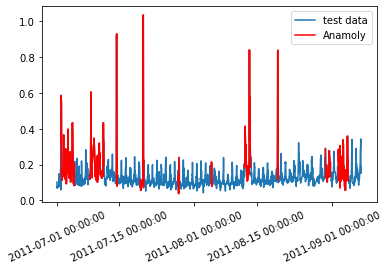

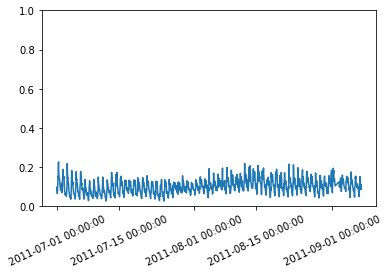

In [165]:
test_len = len(test_value)
anomalous_data_indices = extract_anomalous_indices(TIME_STEPS,anomalies,test_len)
conv1_ae_anomaly_count = len(anomalous_data_indices)
plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly)
plot_dates_values(df_cpc_normal, adjust= True)

## Observation:

We can observe that this autoencoder model built using convolutional layers had reconstructed the data comparatively better than LSTM and MLP autoencoders. We can also observe the decrease in validation loss comparatively.

--------


## Building an Autoencoder with convolutional layers (Number of layers have been decreased to limit the case of overfitting and kernel size has been increased from 5 to 7) 

In [166]:
model_2 = tf.keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_2.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 12, 32)            256       
_________________________________________________________________
dropout_88 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6, 16)             3600      
_________________________________________________________________
conv1d_transpose_25 (Conv1DT (None, 12, 16)            1808      
_________________________________________________________________
dropout_89 (Dropout)         (None, 12, 16)            0         
_________________________________________________________________
conv1d_transpose_26 (Conv1DT (None, 24, 32)            3616      
_________________________________________________________________
conv1d_transpose_27 (Conv1DT (None, 24, 1)           

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.


In [167]:
history_2 = model_2.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose = 1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
12/12 [==============================] - 0s 28ms/step - loss: 0.9041 - val_loss: 0.6629
Epoch 2/50
12/12 [==============================] - 0s 12ms/step - loss: 0.4665 - val_loss: 0.3348
Epoch 3/50
12/12 [==============================] - 0s 14ms/step - loss: 0.3122 - val_loss: 0.2895
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 0.2685 - val_loss: 0.2287
Epoch 5/50
12/12 [==============================] - 0s 13ms/step - loss: 0.2329 - val_loss: 0.1977
Epoch 6/50
12/12 [==============================] - 0s 13ms/step - loss: 0.2054 - val_loss: 0.1691
Epoch 7/50
12/12 [==============================] - 0s 12ms/step - loss: 0.1853 - val_loss: 0.1458
Epoch 8/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1671 - val_loss: 0.1301
Epoch 9/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1518 - val_loss: 0.1213
Epoch 10/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1428 - val_loss: 0.1140
Epoch 11/

Let's plot training and validation loss to see how the training went.


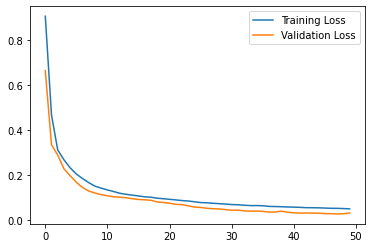

In [190]:
plt.plot(history_2.history["loss"], label="Training Loss")
plt.plot(history_2.history["val_loss"], label="Validation Loss")
plt.legend()

conv2_autoencoder_loss = history_2.history["val_loss"]


## Defining threshold and plotting Absolute loss

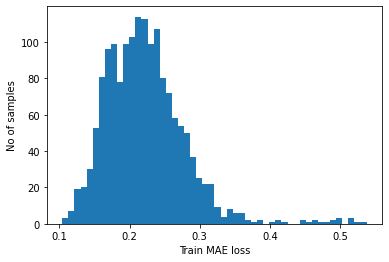

Reconstruction error threshold:  0.5377567854493958


In [169]:
train_mae_loss, pred_data = calculate_loss(model_1,x_train)


plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

let's see how our model has recontructed the second sample.
This is the 24 timesteps from day 2 of our training dataset.


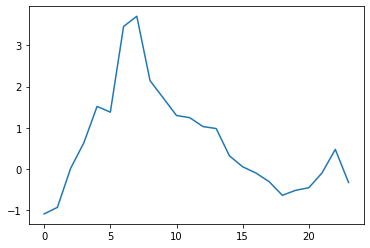

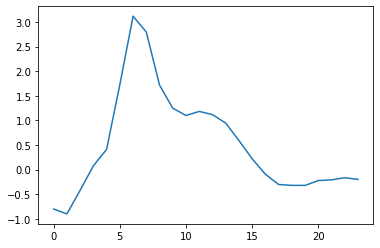

In [170]:
# Checking how the first sequence is learnt
plt.plot(x_train[2])
plt.show()
plt.plot(pred_data[2])
plt.show()


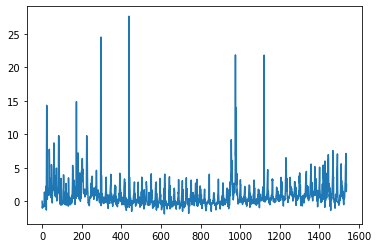

Test input shape:  (1514, 24, 1)


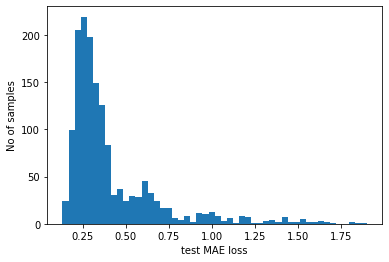

Number of anomaly samples:  307
Indices of anomaly samples:  (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   28,   29,   31,   32,   33,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,  150,  151,  152,  153,  154,  155,  156,
        157,  158,  159,  160,  161,  162,  163,  164,  165,  166,  167,
        168,  169,  170,  171,  172,  173,  174,  175,  176,  177,  178,
        179,  180,  181,  182,  183,  184,  185,  186,  187,  188,  189,
        190,  191,  192,  193,  194,  195,  196,  197,  198,  199,  201,
        202,  203,  204,  205,  206,  207,  208,  209,  210,  

In [171]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_cpc_with_anamoly)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test, _ = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
test_mae_loss, test_pred = calculate_loss(model,x_test)

test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


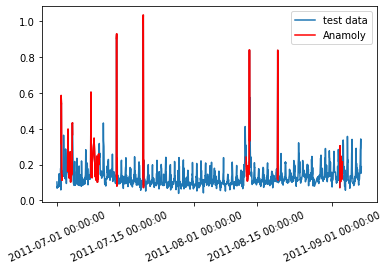

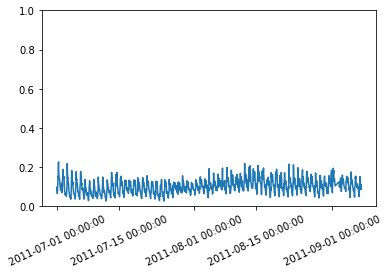

In [172]:
test_len = len(test_value)
anomalous_data_indices = extract_anomalous_indices(TIME_STEPS,anomalies,test_len)

conv2_ae_anomaly_count = len(anomalous_data_indices)

plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly)
plot_dates_values(df_cpc_normal, adjust= True)

## Observation:

We can observe that the model had reconstructed normal data better than the previous convolutional autoencoder. And even validation loss was comparatively lesser than previous one. 

## Building a model with Conv1DLayers ( by defining the threshold using mean squared error and changing the optimizer to RMSprop. As this time series data has a little dependency on the previous time stamp values, RMSprop may perform better) 


In [173]:
model_3 = tf.keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="selu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="selu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="selu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="selu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.01), loss="mse")
model_3.summary()


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 12, 32)            256       
_________________________________________________________________
dropout_90 (Dropout)         (None, 12, 32)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 6, 16)             3600      
_________________________________________________________________
conv1d_transpose_28 (Conv1DT (None, 12, 16)            1808      
_________________________________________________________________
dropout_91 (Dropout)         (None, 12, 16)            0         
_________________________________________________________________
conv1d_transpose_29 (Conv1DT (None, 24, 32)            3616      
_________________________________________________________________
conv1d_transpose_30 (Conv1DT (None, 24, 1)           

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.


In [174]:
history_3 = model_3.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose = 1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
12/12 [==============================] - 0s 26ms/step - loss: 0.3715 - val_loss: 0.1503
Epoch 2/50
12/12 [==============================] - 0s 12ms/step - loss: 0.1898 - val_loss: 0.1049
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.1466 - val_loss: 0.0830
Epoch 4/50
12/12 [==============================] - 0s 12ms/step - loss: 0.1232 - val_loss: 0.0574
Epoch 5/50
12/12 [==============================] - 0s 12ms/step - loss: 0.1039 - val_loss: 0.0715
Epoch 6/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0985 - val_loss: 0.0417
Epoch 7/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0896 - val_loss: 0.0351
Epoch 8/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0807 - val_loss: 0.0298
Epoch 9/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0745 - val_loss: 0.0365
Epoch 10/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0703 - val_loss: 0.0582
Epoch 11/

Let's plot training and validation loss to see how the training went.


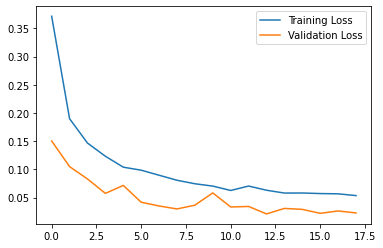

In [175]:
plt.plot(history_3.history["loss"], label="Training Loss")
plt.plot(history_3.history["val_loss"], label="Validation Loss")
plt.legend()

conv3_autoencoder_loss = history_3.history["val_loss"]


There may be few patterns in the training data which allowed the model to study the pattern present in validation data leading to lesser validation loss than training loss

## Defining threshold and plotting counts for Mean Square loss

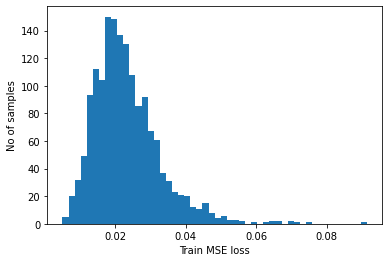

Reconstruction error threshold:  0.09136741665224539


In [183]:


pred_data = model_3.predict(x_train)
train_mse_loss = np.mean(np.square(x_train - pred_data), axis=1)


plt.hist(train_mse_loss, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()


threshold = np.max(train_mse_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the second sample.
This is the 24 timesteps from day 2 of our training dataset.


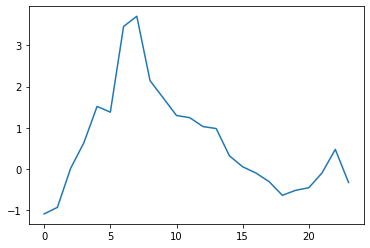

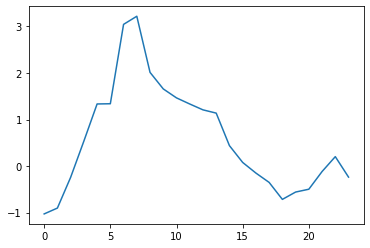

In [184]:
# Checking how the first sequence is learnt
plt.plot(x_train[2])
plt.show()
plt.plot(pred_data[2])
plt.show()


**We can see that model has almost perfectly reconstructed the training data**

Test input shape:  (1514, 24, 1)


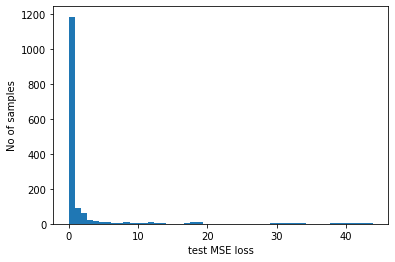

Number of anomaly samples:  833
Indices of anomaly samples:  (array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
        100,  101,  103,  104,  105,  107,  108,  109,  110,  111,  112,
        113,  114,  115,  117,  118,  119,  127,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  151,  152,  

In [185]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_cpc_with_anamoly)
test_value = normalize_test(test_value, training_mean, training_std)
# plt.plot(test_value.tolist())
# plt.show()

# Create sequences from test values.
x_test, _ = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Calculating test MSE loss.
test_pred = model_3.predict(x_test)
test_mae_loss = np.mean(np.square(x_test - test_pred), axis=1)


test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


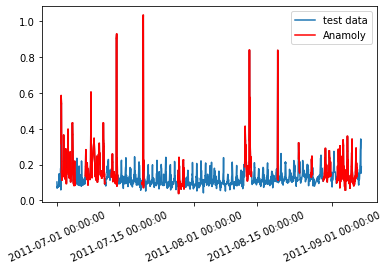

In [186]:
test_len = len(test_value)
anomalous_data_indices = extract_anomalous_indices(TIME_STEPS,anomalies,test_len)

conv3_ae_anomaly_count = len(anomalous_data_indices)

plot_the_anomaly(anomalous_data_indices, df_cpc_with_anamoly)
# plot_dates_values(df_cpc_normal, adjust= True)

## Observation:

We can see that change in threshold and optimizer had improved the performance of the autoencoder. This can be observed by looking at the reduction of validation loss and improvement of reconstructed data.

## Comparing the validation loss for each model:

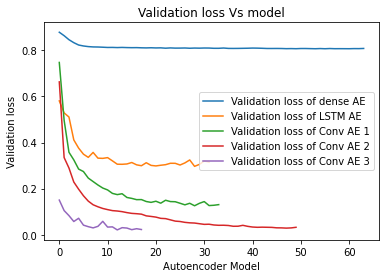

In [192]:
plt.figure()
plt.plot(dense_autoencoder_loss, label = "Validation loss of dense AE")
plt.plot(LSTM_autoencoder_loss, label = "Validation loss of LSTM AE")

plt.plot(conv1_autoencoder_loss, label = "Validation loss of Conv AE 1")
plt.plot(conv2_autoencoder_loss, label = "Validation loss of Conv AE 2")

plt.plot(conv3_autoencoder_loss, label = "Validation loss of Conv AE 3")

plt.title('Validation loss Vs model')
plt.ylabel('Validation loss')
plt.xlabel('Autoencoder Model')
plt.legend(loc='best')

## Observation:

We can observe that Autoencoder built by convolutional layers performed better than Autoencoders built by LSTM and MLP.  
Comparing the autoencoders built by convolutional layers, we can see that autoencoders which used mean squared loss for defining threshold and RMSprop for optimizer had performed comparatively better.

## Plotting the number of anomalies detected by each autoencoder model

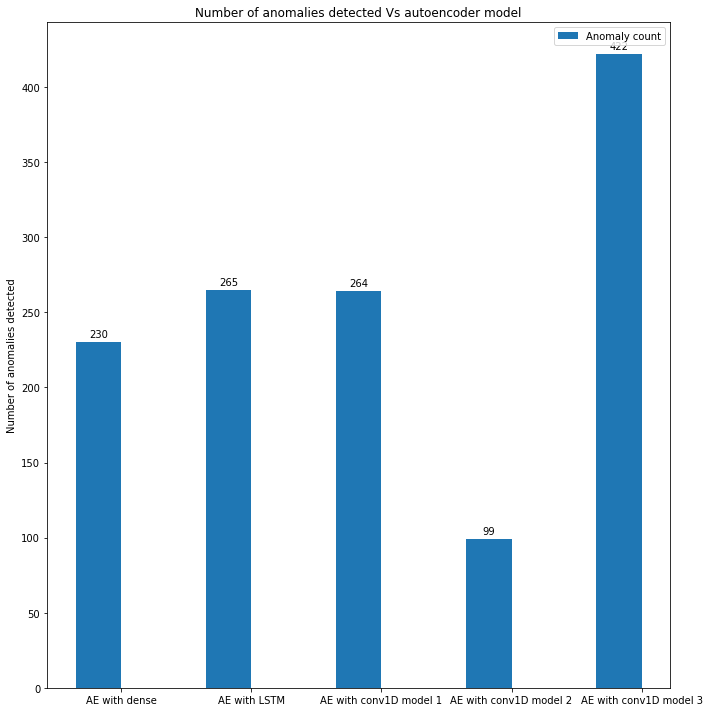

In [202]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['AE with dense', 'AE with LSTM', 'AE with conv1D model 1', 'AE with conv1D model 2','AE with conv1D model 3']
Anomaly_count = [dense_ae_anomaly_count,LSTM_ae_anomaly_count,conv1_ae_anomaly_count,conv2_ae_anomaly_count,conv3_ae_anomaly_count]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, Anomaly_count, width, label='Anomaly count')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of anomalies detected')
ax.set_title('Number of anomalies detected Vs autoencoder model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

AE with dense : Autoencoder built using Dense layers

AE with LSTM : Autoencoder built using LSTM layers

AE with Conv1D model 1 : Autoencoder built using Convolutional layers

AE with Conv1D model 2 : Autoencoder built using Convolutional layers(Number of layers were reduced from previous model)

AE with Conv1D model 3 : Autoencoder built using Convolutional layers( By changing the error metric (to MSE) used to determine threshold and the optimizer (to RMSprop)